# Building a Text-to-SQL Agent with LangGraph & Supabase

This notebook demonstrates how to build an intelligent agent capable of querying a structured database using natural language. By leveraging **LangGraph** for workflow orchestration and **Supabase (PostgreSQL)** for storage, we create a system where an LLM translates user questions into SQL queries, executes them, and summarizes the results.

**Key Concepts:**
* **LangGraph Orchestration:** Managing the flow between the LLM and specific tools.
* **Tool Separation:** Decoupling the `sql_writer` (logic) from the `sql_executor` (action).
* **Dynamic Schema Injection:** Fetching database context dynamically to ensure accurate query generation.

In [21]:
#!pip install langchain[openai] langgraph pypdf langchain-community chromadb langchain-chroma psycopg2-binary

## Config Connections

In [22]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)


# OpenAI API
api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)


# SUPABASE KEY
supabase_key_file = '/content/drive/MyDrive/Password_Supabase.txt'

with open(supabase_key_file, 'r') as file:
    supabase_key = file.read().strip()

os.environ['SUPABASE_KEY'] = supabase_key
print("Supabase key loaded:", os.environ.get('SUPABASE_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True
Supabase key loaded: True


## Database Configuration & Test

In [19]:
import psycopg2

# Database Configuration
DB_CONFIG = {
    "host": "aws-1-ap-southeast-1.pooler.supabase.com",
    "user": "postgres.ayzyngdcnyvzvlnnxxpg",
    "password": os.environ.get('SUPABASE_KEY'),
    "port": "6543",
    "dbname": "postgres"}


# Connection Test
conn = psycopg2.connect(**DB_CONFIG)
cursor = conn.cursor()
cursor.execute("SELECT * FROM products")
results = cursor.fetchall()
print(results)

[(1, 1, 'Smartphone X', 'Latest model with 5G', Decimal('999.00'), 50), (2, 1, 'Wireless Headphones', 'Noise cancelling', Decimal('199.50'), 100), (3, 2, 'Vintage T-Shirt', '100% Cotton', Decimal('25.00'), 200), (4, 2, 'Running Shoes', 'Lightweight and durable', Decimal('85.00'), 30), (5, 3, 'Sci-Fi Novel', 'Best seller 2024', Decimal('15.99'), 500), (6, 4, 'Coffee Maker', 'Automatic drip coffee', Decimal('45.00'), 20)]


In [23]:
from typing_extensions import TypedDict, Literal, Annotated, List
from uuid import uuid4

# LanGraph
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# LangChain
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langchain_chroma import Chroma

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

## Create once GLOBAL_SCHEMA for the Tools

In [24]:
def fetch_schema_once():
    """Run this ONCE outside the graph to save resources."""
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        cursor = conn.cursor()
        cursor.execute("""
            SELECT table_name, column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public';
        """)
        rows = cursor.fetchall()
        conn.close()


        # Format schema
        schema_dict = {}
        for table, col, dtype in rows:
            if table not in schema_dict: schema_dict[table] = []
            schema_dict[table].append(f"{col}")


        return str(schema_dict)
    except Exception as e:
        return "Schema fetch failed."


# Fetch schema immediately so it's ready for the tools
print("--- System: Loading Database Schema... ---")
GLOBAL_SCHEMA = fetch_schema_once()
print (GLOBAL_SCHEMA)
print("--- Schema Loaded! ---")

--- System: Loading Database Schema... ---
{'categories': ['id', 'name'], 'orders': ['order_date', 'total_amount', 'id', 'customer_id', 'status'], 'order_items': ['id', 'order_id', 'product_id', 'quantity', 'unit_price'], 'products': ['id', 'category_id', 'price', 'stock', 'name', 'description'], 'customers': ['id', 'created_at', 'name', 'email', 'country']}
--- Schema Loaded! ---


In [37]:
@tool
def sql_writer(query:str)->str:
  """
  Use this tool to write SQL Queries
  Input: A natural language question about data
  Output: a raw SQL query (text)
  """

  prompt = f"""You are an SQL expert. Given an input question, first create a syntactically correct SQL query to run the schema.
            SCHEMA: {GLOBAL_SCHEMA}
            Write a Postgres SQL query for: {query}
            Return only SQL string, no Markdown.
            """

  response = llm.invoke(prompt)
  return response.content


@tool
def sql_executor(query:str)-> str:
  """
  Use this tool to execute SQL queries properly generated by the writer tool
  Input: A valid SQL string, starting with SELECT.
  """

  try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    cursor.execute(query)
    #conn.close()

    results = cursor.fetchall()
    return str(results)

  except Exception as e:
    return f"SQL Error {e}"


tool_list = [sql_writer, sql_executor]
tool_node = ToolNode(tools = tool_list)
llm_with_tool = llm.bind_tools(tools = tool_list)

## Create Model

In [38]:
class ChatState(TypedDict):
  messages: Annotated[List[BaseMessage], add_messages]


def answer_node(state: ChatState) -> dict:
  human_msg: HumanMessage = state['messages']
  ai_response: AIMessage = llm_with_tool.invoke(input = human_msg)
  return {'messages': [ai_response]}


def route(state: ChatState) -> Literal['end', 'tools']:
  '''
  Should continue Node
  '''
  last_msg = state['messages'][-1]
  if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
    return 'tools'
  return 'end'

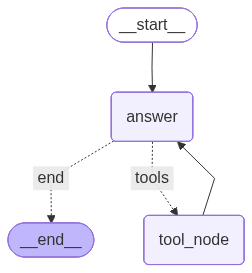

In [39]:
checkpointer = MemorySaver()

# NODES
builder = StateGraph(ChatState)
builder.add_node('answer', answer_node)
builder.add_node('tool_node', tool_node)

# EDGES
builder.add_edge(START, 'answer')
builder.add_conditional_edges('answer', route, {'end': END, 'tools': 'tool_node'})
builder.add_edge('tool_node', 'answer')
builder.add_edge('answer', END)


graph = builder.compile(checkpointer = checkpointer)
graph

In [40]:
cfg:dict[dict] = {'configurable': {'thread_id': str(uuid4())}}

In [41]:
msg = graph.invoke({'messages': [HumanMessage(content = "What are the sales per category?")]}, config = cfg)

In [45]:
for element in msg['messages']:
  if isinstance(element, AIMessage) and not element.tool_calls:
      print(element.content)

The sales per category are as follows:

- **Electronics**: $1198.50
- **Clothing**: $110.00
- **Books**: $15.99


In [46]:
sql_executor.invoke("SELECT * FROM products")

"[(1, 1, 'Smartphone X', 'Latest model with 5G', Decimal('999.00'), 50), (2, 1, 'Wireless Headphones', 'Noise cancelling', Decimal('199.50'), 100), (3, 2, 'Vintage T-Shirt', '100% Cotton', Decimal('25.00'), 200), (4, 2, 'Running Shoes', 'Lightweight and durable', Decimal('85.00'), 30), (5, 3, 'Sci-Fi Novel', 'Best seller 2024', Decimal('15.99'), 500), (6, 4, 'Coffee Maker', 'Automatic drip coffee', Decimal('45.00'), 20)]"

In [48]:
print(sql_writer.invoke("What are the sales per category?"))

SELECT c.name AS category_name, SUM(oi.quantity * oi.unit_price) AS total_sales
FROM categories c
JOIN products p ON c.id = p.category_id
JOIN order_items oi ON p.id = oi.product_id
JOIN orders o ON oi.order_id = o.id
WHERE o.status = 'completed'
GROUP BY c.name;
